<a href="https://colab.research.google.com/github/HarrisonRBaker/Testing/blob/master/FinalProject/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

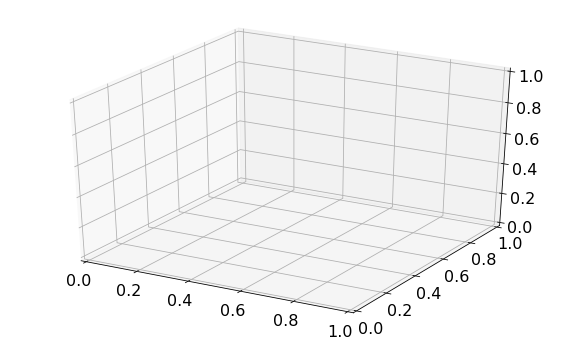

In [17]:
from numpy.core.numeric import indices
#import packages 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initiallizing Variables used throughout
i = 0
j = 0
Mass = 2.5
K = 1
N = 2
M = 50
# Create Mesh grid to be filled
Mesh = np.zeros((M, N, 3))
# Fill the Grid that was created
# This first line moves through the whole array element by element
with np.nditer(Mesh, flags=['multi_index'], op_flags=['readwrite'])as it:
  for i in it:
    # Gets the positions of the elements in the array
    x, y, z = it.multi_index
    # Fills the Mass info of the particles in the mesh
    if z == 0:
      if x < M/2:
        i[...] = Mass
      if x >= M/2:
        i[...] = Mass * 2
    # Sets the pertibation of the mesh in a line
    elif z == 1 and x == M/5:
      Mesh[x][y][z] = 1
    # Fills the rest of the array with zeros for Z Position and Velocity
    else:
      i[...] = 0



In [18]:
def Distance(Grid, X_Pos1, Y_Pos1, X_Pos2, Y_Pos2):
  # Checks if either position is outside of the array
  if X_Pos1 == -1 or Y_Pos1 == -1 or X_Pos2 == -1 or Y_Pos2 == -1 or X_Pos1 == M or Y_Pos1 == N or X_Pos2 == M or Y_Pos2 == N:
    # checks if the first position is out of the array
    if X_Pos1 == -1 or Y_Pos1 == -1 or X_Pos1 == M or Y_Pos1 == N:
      # Sets both points to the same Z height
      Z_Pos1 = Grid[X_Pos2][Y_Pos2][1]
      Z_Pos2 = Grid[X_Pos2][Y_Pos2][1]
    # checks if the second position is out of the array
    if X_Pos2 == -1 or Y_Pos2 == -1 or X_Pos2 == M or Y_Pos2 == N:
      # Sets both points to the same Z height
      Z_Pos1 = Grid[X_Pos1][Y_Pos1][1]
      Z_Pos2 = Grid[X_Pos1][Y_Pos1][1]
    # Finds the difference in the points
    Dist = Z_Pos1 - Z_Pos2
  # Used for all points within the bounds of the array
  else:
    # Pulls Z Positions from the array
    Z_Pos1 = Grid[X_Pos1][Y_Pos1][1]
    Z_Pos2 = Grid[X_Pos2][Y_Pos2][1]
    # Finds the difference in the points
    Dist = Z_Pos1 - Z_Pos2
  #Returns distance between points
  return (Dist)

In [19]:
def ForceCalculation(Grid, X_Pos, Y_Pos):
  # Finds spring force from the point to the right of the current point
  Force_X1 = K * 10 * (1-Distance(Grid, X_Pos, Y_Pos, X_Pos + 1, Y_Pos))
  # Finds spring force from the point to the left of the current point
  Force_X2 = K * 10 * (1-Distance(Grid, X_Pos, Y_Pos, X_Pos - 1, Y_Pos))
  # Adds up the forces from the points left and right of the point
  Force_X = Force_X1 + Force_X2
  # Finds spring force from the point above the current point
  Force_Y1 = K * 10 * (1-Distance(Grid, X_Pos, Y_Pos, X_Pos, Y_Pos + 1))
  # Finds spring force from the point below the current point
  Force_Y2 = K * 10 * (1-Distance(Grid, X_Pos, Y_Pos, X_Pos, Y_Pos - 1))
  # Adds up the forces from above and below the point
  Force_Y = Force_Y1 + Force_Y2
  # Checks if the points are above the surface
  if Grid[X_Pos][Y_Pos][1] > 0:
    # Sets gravity to Mass of the point times acceleration due to gravity
    Gravity = (Grid[X_Pos][Y_Pos][0] * -9.81)
  # Used if the points are at zero or below in Z value
  else:
    # Sets Gravity to Zero so that the whole mesh doesn't just fall down
    Gravity = 0
  # Adds up all of the forces calculated
  Force = Force_X + Force_Y + Gravity
  # Returns Total force calculated for the point
  return Force

In [20]:
def Acceleration(Grid, X_Pos, Y_Pos):
  # Calls the Force function to get the net force on the point
  Force = ForceCalculation(Grid, X_Pos, Y_Pos)
  # Pulls the Mass of the point from the array
  Mass_XY = Grid[X_Pos][Y_Pos][0]
  # Finds the acceleration at the point from the net force over the mass
  Accel = Force / Mass_XY
  # Returns the acceleration of the point
  return Accel

In [21]:
def Velocity(Grid, X_Pos, Y_Pos, time_step):
  # Calls the acceleration function to find the acceleration at the point
  Accel = Acceleration(Grid, X_Pos, Y_Pos)
  # Finds the change in velocity due to the acceleration
  Vel_New = Grid[X_Pos][Y_Pos][2] + Accel * time_step
  # Returns the new velocity
  return Vel_New

In [22]:
def Position(Grid, X_Pos, Y_Pos, time_step):
  # Calls the Velocity function to get the new velocity at the point
  Vel = Velocity(Grid, X_Pos, Y_Pos, time_step)
  # Uses the new velocity to find a new position
  Pos_New = Grid[X_Pos][Y_Pos][1] + Vel * time_step
  # Returns the new velocity and position of the point
  return Pos_New, Vel

In [23]:
def UpdateMesh(Grid, time_step):
  # Sets up grid to hold values
  New_Grid = np.zeros((M, N, 2))
  # Sets up indexing to loop through array
  with np.nditer(Grid, flags=['multi_index'], op_flags=['readonly'])as it:
    for i in it:
      X_Pos, Y_Pos, Z_Pos = it.multi_index
      # Checks if the indexing is at the Z Position spot of the array
      if Z_Pos == 1:
        # Calls Position to get new position and velocity
        New_Pos, Vel_New = Position(Grid, X_Pos, Y_Pos, time_step)
        # Populates Position and Velocity in Updating Mesh
        New_Grid[X_Pos][Y_Pos][0] = New_Pos
        New_Grid[X_Pos][Y_Pos][1] = Vel_New
  # Sets up indexing to loop through array
  with np.nditer(Grid, flags=['multi_index'], op_flags=['readwrite'])as it:
    for i in it:
      X_Pos, Y_Pos, Z_Pos = it.multi_index
      # Checks if the index is in the Z Position spot
      if Z_Pos == 1:
        # Pulls Updated Position to original Mesh
        Grid[X_Pos][Y_Pos][1] = New_Grid[X_Pos][Y_Pos][0]
        # Checks if the index is in the Velocity spot
      if Z_Pos == 2:
        # Pulls Updated Velocity to original Mesh
        Grid[X_Pos][Y_Pos][2] = New_Grid[X_Pos][Y_Pos][1]
  #Returns updated Mesh
  return Grid

In [24]:
def Propogate_Wave(time, Mesh):
  # Sets loop index to zero
  l = 0
  # Loop to update Mesh for the given time
  while l < (time / .00001):
    # Updates mesh and stores it in the Original Mesh value
    Mesh = UpdateMesh(Mesh, .00001)
    # Increases Index
    l +=1
  # Prints time that passed
  print("time:" + str(l * .00001) + "(sec)")
  # Initiallizes Z Position array for graphing
  Z = np.zeros((M, N), dtype=object)
  # Sets up indexing to move through array
  with np.nditer(Mesh, flags=['multi_index'], op_flags=['readwrite'])as it:
      for i in it:
        X_Pos, Y_Pos, Z_Pos = it.multi_index
        # Checks if the index is in the Z Position spot
        if Z_Pos == 1:
          # Fills Z Value array for graphing with Z Position in Mesh
          Z[X_Pos][Y_Pos] = Mesh[X_Pos][Y_Pos][Z_Pos]
  # Initializes x and y arrays of the size of the Mesh
  x = np.linspace(0, M, M)
  y = np.linspace(0, N, N)
  # Creates Mesh grid of the x and y values for graphing
  Y, X = np.meshgrid(y,x)
  # Plots a 3D graph using the arrays of position information
  ax = plt.axes(projection='3d')
  ax.contour3D(X, Y, Z, 1000, cmap='viridis')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.view_init(60, 35)
  plt.savefig("demo.png")

time:1.0(sec)


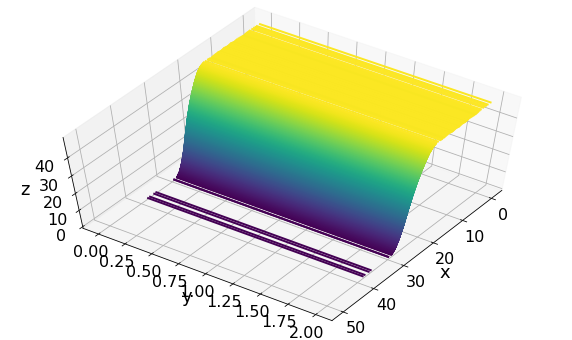

In [28]:
# Set Value in function to time in seconds to run (This can take a very long time depending on the mesh size and time)
# Each run of the Propogate Wave function continues the motion of the wave and does not reset the wave surface
# Time processing examples: (1 second -> ~2.5 Min.) (5 Second -> ~13 Min) (10 Seconds -> ~26 Min)
Propogate_Wave(1, Mesh)